# Train a CNN based model on audio spectrogram data
Kartik Nanda, March 2020

Thanks a lot to the FastAI_Audio team (https://github.com/mogwai/fastai_audio)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
import os
import sys
import csv
import shutil
from pathlib import Path
from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random

In [23]:
#To have reproducible results with fastai you must also set num_workers=1 in your databunch, and seed=seed
#in split_by_rand_pct
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

In [24]:
from fastai.vision import *
from fastai.metrics import error_rate

sys.path.append("..")
from audio import *
torchaudio.set_audio_backend('soundfile')

## Define Constants

In [25]:
# Define some important constants - this needs to be moved to a separate included file
n_fft = 2048            # used for STFT: # samples used to generate fft
sample_rate = [44100, 8192, 1024]  # sample rates of the audio clips
hop_fac = [2, 4, 32]    # to determine hop_length
cdur = 5                # clip duration in seconds
n_mels = 224            # num of mel freq bands output
ref = 32768             # reference power for mel db calculation

## Path Setup

In [6]:
# Define paths
# path_raw_audio contains the audio clips and associated meta data
# path_dataset - the audio clips are converted to images (mel spectrogram) and saved here
# path_features - the output of the CNN, for further processing
path_proj = Path.cwd().parent                                        # The project directory

# datasets (audio files)
path_uw_dataset = path_proj/'datasets'/'data_uw_sounds'               # The downloaded dataset incl. audio files
path_ESC_dataset = path_proj/'datasets'/'ESC-50-master'/'audio'      # Dataset for CNN train and valid 
file_csv  = "../meta/esc50.csv"

path_features = path_proj/'audio_features'/'audio_cnn_1'             # The output folder - where the features are saved
path_model = path_proj/'models'/'audio_cnn_1'                        # models are saved here

In [8]:
(path_ESC_dataset/file_csv).exists(), path_model.exists(), path_ESC_dataset.exists(), path_uw_dataset.exists()

(True, True, True, True)

In [9]:
# Read the meta data file for the ESC-50 dataset
df = pd.read_csv(path_ESC_dataset/file_csv)
df.head(5)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Step 1: Training on a single fold

### Setup

First we set our spectrogram config. The value vars are defined elsewhere (currently a cell at the top of this file)

In [30]:
sg_cfg= SpectrogramConfig(n_fft = n_fft, hop_length=int(n_fft/4), n_mels=n_mels, win_length= n_fft, 
                          top_db=80, f_min=0.0, f_max=22050.0, db_ref=ref)
cfg = AudioConfig(cache=True, duration=cdur*1000, sg_cfg=sg_cfg)

We can set our validation fold to five and split our files up into Train (folds 1, 2, 3, and 4) and Valid (fold 5).

In [31]:
valid_fold = 5
files_train = [f for f in df.loc[df['fold'] != valid_fold].filename]
files_valid = [f for f in df.loc[df['fold'] == valid_fold].filename]
len(files_train), len(files_valid)

(1600, 400)

Next we load up an AudioList with our data, using split_by_files to separate valid and training. We don't do any transforms because we will be using mixup, which is made incredibly easy by fastai and works very well for acoustic scene classification.

In [32]:
#num_workers = 1 for reproducibility, see https://docs.fast.ai/dev/test.html#getting-reproducible-results
#tfms = get_spectro_transforms(mask_frequency=False, mask_time=False, size=(256,430))
tfms=None
db_audio = (AudioList.from_csv(path_ESC_dataset, file_csv, config=cfg)
                .split_by_files(files_valid).label_from_df("category")
                .transform(tfms=tfms)
                .databunch(bs=16, num_workers = 1))

------------------------------------------------------------
File: /home/jupyter/datasets/ESC-50-master/audio/1-100032-A-0.wav
Total Length: 5.0 seconds
Number of Channels: 1
Label: dog
0.01s-5.01s of original clip


Channel 0.0 (224x430):


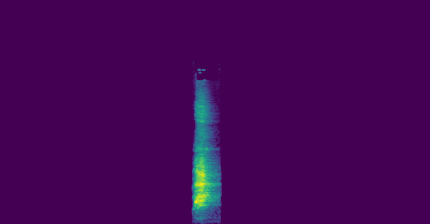

------------------------------------------------------------
File: /home/jupyter/datasets/ESC-50-master/audio/1-100038-A-14.wav
Total Length: 5.0 seconds
Number of Channels: 1
Label: chirping_birds
0.01s-5.01s of original clip


Channel 0.0 (224x430):


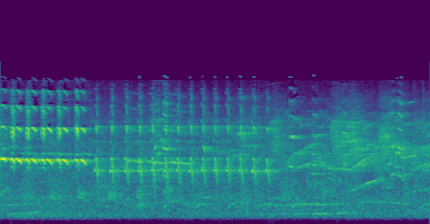

------------------------------------------------------------
File: /home/jupyter/datasets/ESC-50-master/audio/1-100210-A-36.wav
Total Length: 5.0 seconds
Number of Channels: 1
Label: vacuum_cleaner
0.01s-5.01s of original clip


Channel 0.0 (224x430):


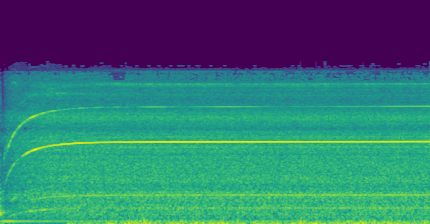

In [33]:
db_audio.show_batch()

In [34]:
db_audio.train_ds[0][0].shape

torch.Size([1, 224, 430])

### Training
Using densenets (121 and 161) since they have been used by the FastAI_Audio team. This is without having done a comprehensive search of the available architectures. More work is needed.

In [35]:
learn = audio_learner(db_audio, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()

In [18]:
learn

Learner(data=AudioDataBunch;

Train: AudioLabelList (1600 items)
x: AudioList
AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz),AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz),AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz),AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz),AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz)
y: CategoryList
dog,chirping_birds,vacuum_cleaner,vacuum_cleaner,thunderstorm
Path: /home/jupyter/datasets/ESC-50-master/audio;

Valid: AudioLabelList (400 items)
x: AudioList
AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz),AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz),AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz),AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz),AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz)
y: CategoryList
pig,pig,pig,pig,pig
Path: /home/jupyter/datasets/ESC-50-master/audio;

Test: None, model=Sequential(
  (0): Sequential(


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


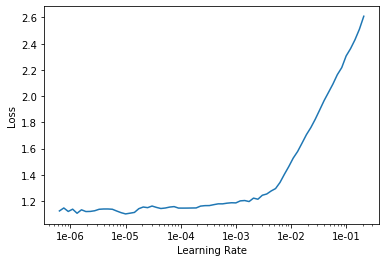

In [39]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.071118,0.507757,0.877500,00:49
1,1.085221,0.499296,0.875000,00:49
2,1.123555,0.491288,0.880000,00:49
3,1.094595,0.490843,0.882500,00:49
4,1.077155,0.498397,0.877500,00:49
5,1.087754,0.494002,0.877500,00:49
6,1.104203,0.496011,0.877500,00:49
7,1.067348,0.501492,0.882500,00:49
8,1.107782,0.497466,0.872500,00:49
9,1.135673,0.499460,0.870000,00:49


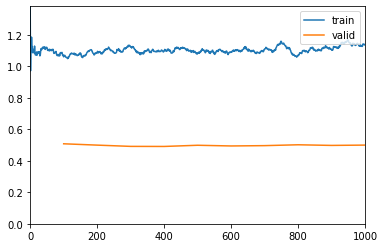

In [40]:
learn.fit_one_cycle(10, slice(1e-5))

In [38]:
learn.save(path_model/'ESC50-stage1')

In [37]:
learn.export(path_model/'87peakacc-stg1')

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

In [39]:
len(db_audio.valid_ds)==len(losses)==len(idxs)

True

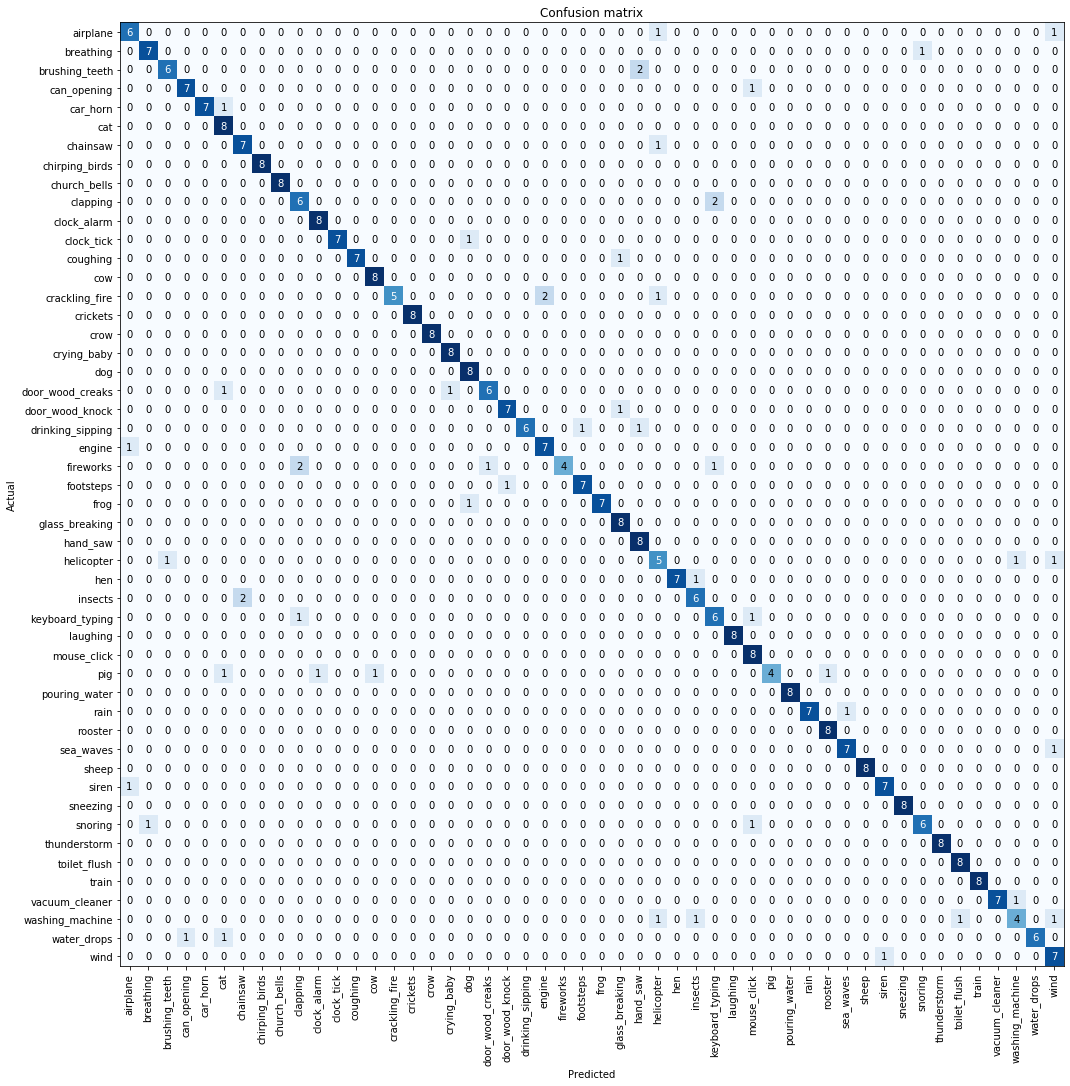

In [40]:
interp.plot_confusion_matrix(figsize=(15,15))

In [41]:
interp.most_confused(min_val=2)

[('brushing_teeth', 'hand_saw', 2),
 ('clapping', 'keyboard_typing', 2),
 ('crackling_fire', 'engine', 2),
 ('fireworks', 'clapping', 2),
 ('insects', 'chainsaw', 2)]

## Step 3: Inference

Load the trained model and run inference on it. In our case we want to extract activations from one of the final layers for postprocessing.

In [93]:
learn2 = load_learner(path_model, '87peakacc-stg1')

In [94]:
# set model in eval mode
m = learn2.model.eval()
m

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affin

Define a function to get the activations

In [111]:
# Return activations
from fastai.callbacks.hooks import *

def get_activations(m, x):
    with hook_output(m.model[1][4]) as hook_a:   # output of the flatten() layer after concat of maxpool and avgpool of the CNN output
#         preds = m(data.one_item(x)[0])
        preds = m.predict(x)
    return hook_a.stored[0].cpu()

In [119]:
dd = db_audio.train_ds[1][0]
learn2.predict(dd)

(Category chirping_birds,
 tensor(7),
 tensor([6.7877e-05, 1.0940e-05, 2.0557e-04, 6.0298e-05, 1.2797e-04, 1.8037e-05,
         6.5804e-05, 9.9059e-01, 1.2007e-04, 2.9191e-05, 3.4127e-05, 2.2000e-04,
         1.0602e-04, 9.6868e-06, 2.3006e-05, 1.3050e-04, 1.6393e-04, 2.5917e-04,
         2.6755e-05, 1.7205e-05, 8.3921e-05, 3.8560e-05, 9.7548e-06, 3.1918e-04,
         7.4384e-06, 1.1508e-04, 5.6287e-04, 9.0958e-06, 1.0397e-03, 3.7837e-04,
         1.6095e-05, 2.8017e-05, 7.6402e-04, 1.7889e-05, 1.3365e-04, 3.7518e-05,
         9.0592e-04, 3.2158e-04, 1.0156e-04, 5.7087e-04, 1.7641e-04, 2.3000e-04,
         5.1010e-06, 2.4059e-05, 9.0984e-05, 9.1756e-04, 5.7263e-05, 5.5963e-04,
         5.4646e-05, 1.3246e-04]))

In [105]:
# i1 = db_audio.train_ds[0][0]
audio_predict(learn2, dd)

(Category chainsaw,
 tensor(6),
 tensor([0.0064, 0.0076, 0.0070, 0.0082, 0.0026, 0.0008, 0.2206, 0.0441, 0.1033,
         0.0168, 0.0267, 0.0275, 0.0032, 0.0143, 0.0015, 0.0475, 0.0243, 0.0263,
         0.0040, 0.0057, 0.0026, 0.0007, 0.0010, 0.0022, 0.0011, 0.0022, 0.0267,
         0.0095, 0.0097, 0.0010, 0.0090, 0.0013, 0.0019, 0.0013, 0.0095, 0.0004,
         0.0652, 0.0015, 0.0036, 0.0057, 0.0282, 0.0056, 0.0011, 0.0003, 0.0015,
         0.0018, 0.1798, 0.0189, 0.0023, 0.0060]))

In [116]:
learn2.data.x.config

AudioConfig(cache=True, duration=None, max_to_pad=None, pad_mode='zeros', remove_silence=None, use_spectro=True, mfcc=False, delta=False, silence_padding=200, silence_threshold=20, segment_size=None, resample_to=None, standardize=False, downmix=False, sg_cfg=SpectrogramConfig(f_min=0.0, f_max=22050.0, hop_length=256, n_fft=2560, n_mels=128, pad=0, to_db_scale=True, top_db=100, win_length=None, n_mfcc=20))

In [117]:
learn.data.x.config

AudioConfig(cache=True, duration=None, max_to_pad=None, pad_mode='zeros', remove_silence=None, use_spectro=True, mfcc=False, delta=False, silence_padding=200, silence_threshold=20, segment_size=None, resample_to=None, standardize=False, downmix=False, sg_cfg=SpectrogramConfig(f_min=20.0, f_max=22050.0, hop_length=512, n_fft=1024, n_mels=128, pad=0, to_db_scale=True, top_db=80, win_length=None, n_mfcc=20))

In [118]:
al = AudioList([dd], path=dd.path, config=learn.data.x.config)
ai = AudioList.open(al, dd.path)
learn2.predict(ai)

(Category chirping_birds,
 tensor(7),
 tensor([6.7877e-05, 1.0940e-05, 2.0557e-04, 6.0298e-05, 1.2797e-04, 1.8037e-05,
         6.5804e-05, 9.9059e-01, 1.2007e-04, 2.9191e-05, 3.4127e-05, 2.2000e-04,
         1.0602e-04, 9.6868e-06, 2.3006e-05, 1.3050e-04, 1.6393e-04, 2.5917e-04,
         2.6755e-05, 1.7205e-05, 8.3921e-05, 3.8560e-05, 9.7548e-06, 3.1918e-04,
         7.4384e-06, 1.1508e-04, 5.6287e-04, 9.0958e-06, 1.0397e-03, 3.7837e-04,
         1.6095e-05, 2.8017e-05, 7.6402e-04, 1.7889e-05, 1.3365e-04, 3.7518e-05,
         9.0592e-04, 3.2158e-04, 1.0156e-04, 5.7087e-04, 1.7641e-04, 2.3000e-04,
         5.1010e-06, 2.4059e-05, 9.0984e-05, 9.1756e-04, 5.7263e-05, 5.5963e-04,
         5.4646e-05, 1.3246e-04]))

In [113]:
z = get_activations(learn2,db_audio.train_ds[1][0])

In [115]:
z.shape

torch.Size([512])

In [124]:
path_uw_data = path_proj/'datasets'/'data_uw_sounds'
path_uw_data.exists()

True

In [126]:
tfms=None
db_test = AudioList.from_folder(path_uw_data, config=cfg)


In [129]:
db_audio.train_ds[1][0]

AudioItem AudioItem 5.0 seconds (1 channels, 220500 samples @ 44100hz)

In [130]:
db_test[0]

AudioItem AudioItem 4.0 seconds (1 channels, 176400 samples @ 44100hz)

In [133]:
learn2.predict(db_test[0])

(Category insects,
 tensor(30),
 tensor([3.0820e-03, 3.1887e-05, 3.4978e-04, 5.1586e-04, 1.8697e-03, 6.7170e-03,
         2.3166e-03, 2.1603e-03, 8.2984e-03, 6.2183e-04, 6.7685e-04, 5.1816e-04,
         1.3064e-03, 2.2591e-01, 1.0952e-03, 6.9674e-04, 1.4907e-04, 8.9283e-04,
         1.7086e-03, 3.6547e-04, 5.3985e-03, 3.2008e-03, 1.4939e-03, 5.9606e-04,
         7.4361e-03, 3.4913e-04, 1.7258e-04, 6.7881e-04, 1.3811e-04, 5.0126e-03,
         6.4341e-01, 1.0118e-03, 5.0999e-04, 8.9559e-04, 1.7131e-03, 3.9206e-03,
         3.4517e-04, 6.6642e-04, 4.6364e-04, 6.8244e-04, 1.6676e-02, 5.8754e-04,
         3.3655e-03, 2.3686e-03, 2.6750e-02, 1.4387e-03, 7.5890e-04, 1.7586e-03,
         6.9812e-03, 1.9421e-03]))

In [134]:
db_test[0].path

PosixPath('/home/jupyter/datasets/data_uw_sounds/humpback_whale-206.wav')

In [135]:
al = AudioList([db_test[0]], path=db_test[0].path, config=learn.data.x.config)
ai = AudioList.open(al, db_test[0].path)
learn2.predict(ai)

(Category insects,
 tensor(30),
 tensor([3.0820e-03, 3.1887e-05, 3.4978e-04, 5.1586e-04, 1.8697e-03, 6.7170e-03,
         2.3166e-03, 2.1603e-03, 8.2984e-03, 6.2183e-04, 6.7685e-04, 5.1816e-04,
         1.3064e-03, 2.2591e-01, 1.0952e-03, 6.9674e-04, 1.4907e-04, 8.9283e-04,
         1.7086e-03, 3.6547e-04, 5.3985e-03, 3.2008e-03, 1.4939e-03, 5.9606e-04,
         7.4361e-03, 3.4913e-04, 1.7258e-04, 6.7881e-04, 1.3811e-04, 5.0126e-03,
         6.4341e-01, 1.0118e-03, 5.0999e-04, 8.9559e-04, 1.7131e-03, 3.9206e-03,
         3.4517e-04, 6.6642e-04, 4.6364e-04, 6.8244e-04, 1.6676e-02, 5.8754e-04,
         3.3655e-03, 2.3686e-03, 2.6750e-02, 1.4387e-03, 7.5890e-04, 1.7586e-03,
         6.9812e-03, 1.9421e-03]))

In [136]:
z = get_activations(learn2,db_test[0])
z.shape

torch.Size([512])

In [137]:
len(db_test)

800

In [138]:
# create a list of activations from training images and validation images
x_act = []
for i in range (len(db_test)):
    x_act.append(get_activations(learn2,db_test[i]))

len(x_act)

AttributeError: 'list' object has no attribute 'shape'

In [144]:
stacked_act = torch.stack(x_act)
stacked_act.shape

torch.Size([800, 512])

In [147]:
stacked_act.numpy().shape

(800, 512)

In [151]:
fnm = path_features/'uw_sounds_model_ESC50_stg1.csv'
np.savetxt(fnm, stacked_act.numpy(), delimiter=",")